In [1]:
using Unitful, UnitfulRecipes           # Unidades físicas
using FFTW                              # Transformadas de Fourier
using Plots, PlotThemes, ColorSchemes   # Gráficos
using Spectra                           # Para encontrar el fwhm
using UnPack

import PhysicalConstants.CODATA2014: c_0
c = c_0 |> u"km/ps"

theme(:juno)
default(size=(800,400), linewidth=2, palette=:seaborn_deep6)

Al igual que en el problema anterior, adaptamos las funciones `fft` y `ifft` para que admitan valores con unidades.

In [2]:
function ufft(y, dim=1)
    yval, yunit = ustrip.(y), unit(y[1])
    return fft(yval, dim)*yunit
end
function uifft(y, dim=1)
    yval, yunit = ustrip.(y), unit(y[1])
    return ifft(yval, dim)*yunit
end

uifft (generic function with 2 methods)

Ya que vamos a trabajar con más de un tipo de fibra, definimos un tipo de dato que represente los specs de una fibra óptica. 

In [3]:
struct Fibra γ; α; end

SMF = Fibra(1.2u"W^(-1)*km^(-1)", uconvertp(NoUnits,0.02u"dB")*u"km^-1") 
NZ_DSF = Fibra(1.8u"W^(-1)*km^(-1)", uconvertp(NoUnits,0.22u"dB")*u"km^-1")

Fibra(1.8 km^-1 W^-1, 1.0519618738232228 km^-1)

Elegimos el número de puntos en el que vamos a discretizar el dominio, y elegimos propagar un pulso de ancho de $10\,\text{ps}$. Definimos el vector $z$ de $0$ a $80 \, \text{km}$

In [4]:
N = 512

T0 = 10u"ps"
B0 = 1/T0 |> u"GHz"

z = range(0u"km", 80u"km", N)

(0.0:0.15655577299412915:80.0) km

Elegimos la fibra SMF y un pulso con potencia de $1\,\text{mW}$. En función de esto calculamos la longitud característica de no-linealidad $L_{NL}$ y la de atenuación $L_{eff}$

In [5]:
fibra = SMF
P0 = 10u"mW"

Leff = 1/fibra.α
LNL = 1/(fibra.γ*P0) |> u"km"

println("Longitud característica de atenuación = $Leff\nLongitud característica de no-lineal. = $LNL")

Longitud característica de atenuación = 0.9954054173515269 km
Longitud característica de no-lineal. = 83.33333333333333 km


Definimos un vector de frecuencias en función del ancho final del espectro en el caso con más SPM (máximo $\gamma$, máximo $P_0$), y el vector de tiempo en función de la resolución del vector de frecuencias. Sobre ese vector de tiempo definimos el pulso gaussiano de potencia $P_0$

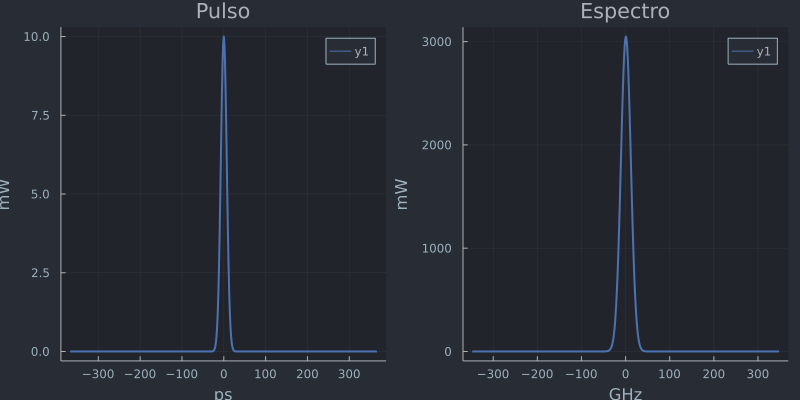

In [6]:
ϕmax = NZ_DSF.γ*100u"mW"*z[end]
Bf = sqrt(1+4/(3*sqrt(3))*ϕmax)*B0

f = range(-Bf, Bf, N)

Δt = 1/(f[2]-f[1]) |> u"ps"
t = fftfreq(N, Δt) |> fftshift;

At0 = sqrt(P0)*exp.(-t.^2/(2T0^2))
Af0 = ufft(At0) |> fftshift

p1 = plot(t, At0.^2, title="Pulso")
p2 = plot(f, abs.(Af0).^2, title="Espectro")
plot(p1, p2)

Definimos una grilla de coordenadas discretas $(i,\, j)$ en donde vamos a evaluar el problema. Esta grilla se va a usar tanto para indexar coordenadas $(z,\, t)$ como $(z,\, f)$.

In [7]:
ij = Iterators.product(1:N, 1:N) |> collect;

Para para calcular la evolución del espectro a lo largo de la fibra, usamos el resultado  
$$A(z,t) = A(0, t) \exp\left[i\gamma \lvert A(z,0)\rvert^2z\right] \longrightarrow A_t[i, j] = A_{t0}[j]\exp\left[i\gamma \lvert A_{t0}[j]\rvert^2z_i\right]$$

In [8]:
A((i, j)) = At0[j]*exp(im*fibra.γ*abs(At0[j])^2*z[i])

A (generic function with 1 method)

Evaluamos $A_t[i,j]$ en los puntos $(i,\, j) \leftrightarrow(z,\, t)$. Transformamos Fourier a lo largo de la dimensión $j$ para obtener el resultado $A_f[i,j]$ en el dominio $(i,\, j) \leftrightarrow(z,\, f)$

In [9]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2);

Visualizamos la evolución de la forma del pulso y del espectro en forma _heatmap_

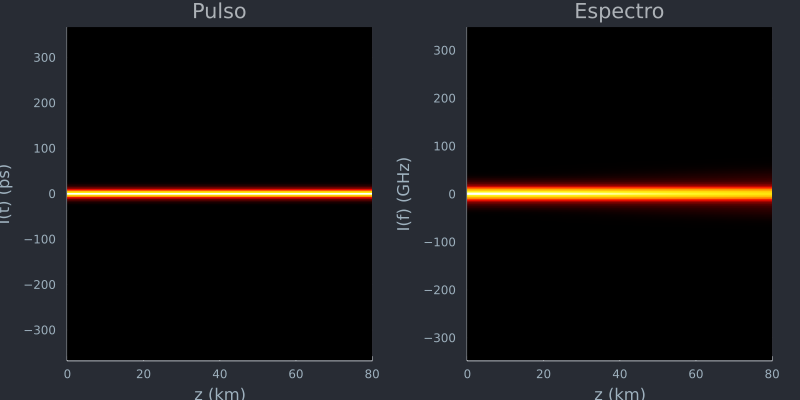

In [10]:
function heatmap_pulse(z, t, At, f, Af)
    p1 = heatmap(z, t, abs.(At').^2, xlabel="z", ylabel="I(t)", title="Pulso")
    p2 = heatmap(z, f, abs.(Af').^2, xlabel="z", ylabel="I(f)", title="Espectro")
    plot(p1, p2, layout=(1,2), colorbar=false, zaxis=:log)
end

heatmap_pulse(z, t, At, f, Af)

Y también con una animación que muestra la forma del pulso mientras este se propaga a través de la fibra

┌ Info: Saved animation to 
│   fn = /tmp/jl_llvL1y.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_llvL1y.gif")
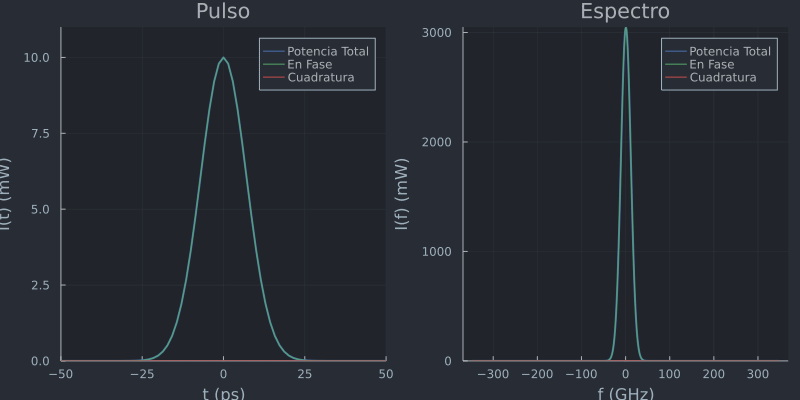

In [11]:
function animate_pulse(t, At, f, Af)
    ymaxf = maximum(abs.(Af).^2)
    ymaxt = maximum(abs.(At).^2)*1.1
    xlims = (-5*T0, 5*T0)
    @gif for i in 1:N   
        p2 = plot(f, abs.(Af[i,:]).^2, linewidth=2, ylims=(0u"W", ymaxf), label="Potencia Total", xlabel = "f", ylabel = "I(f)", title="Espectro")
        plot!(f, real(Af[i,:]).^2, label="En Fase", linewidth=1); 
        plot!(f, imag(Af[i,:]).^2, label="Cuadratura", linewidth=1)

        p1 = plot(t, abs.(At[i,:]).^2, linewidth=2, xlims=xlims, ylims=(0u"W", ymaxt), label="Potencia Total", xlabel = "t", ylabel = "I(t)", title="Pulso")
        plot!(t, real(At[i,:]).^2, label="En Fase", linewidth=1); 
        plot!(t, imag(At[i,:]).^2, label="Cuadratura", linewidth=1)
        plot(p1, p2, layout=(1,2))
    end every 8
end

animate_pulse(t, At, f, Af)

Ahora consideramos el efecto de la atenuación, usamos el resultado

$$A(z,t) = A(0, t) \exp\left[i\gamma \lvert A(z,0)\rvert^2z_{eff}\right] \longrightarrow A_t[i, j] = A_{t0}[j]\exp\left[i\gamma \lvert A_{t0}[j]\rvert^2z_{eff}[i]\right]$$
Donde la longitud efectiva es: $z_{eff} = \dfrac{1-e^{-\alpha z}} \alpha$

In [12]:
function A_att((i, j))
    zeff = (1-exp(-fibra.α*z[i]))/fibra.α
    return At0[j]*exp(im*fibra.γ*abs(At0[j])^2*zeff)
end

At = A_att.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2);

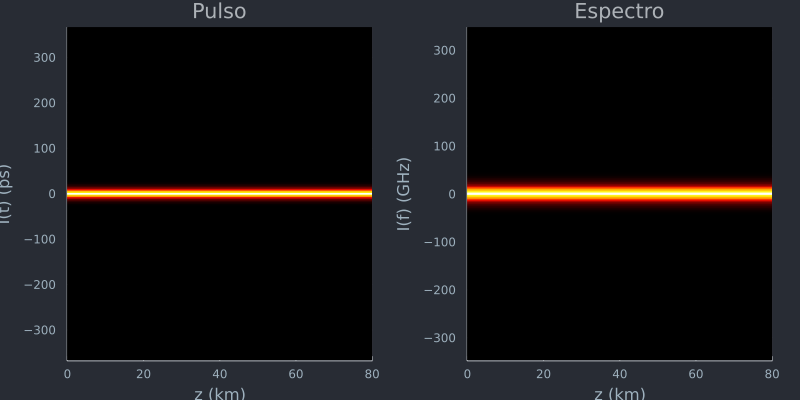

In [13]:
heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_n2IFwi.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_n2IFwi.gif")
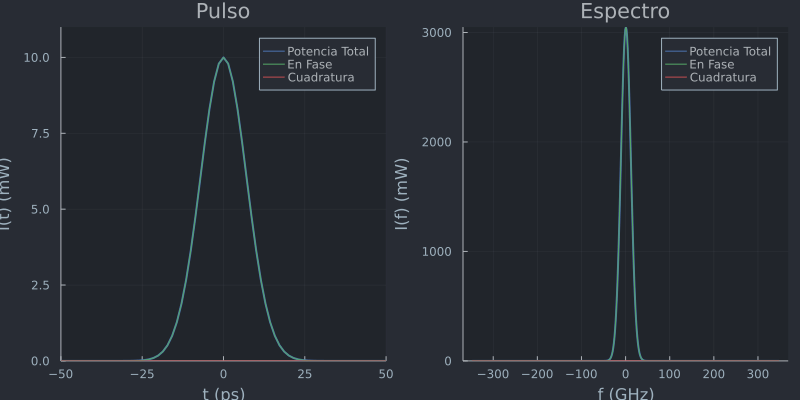

In [14]:
animate_pulse(t, At, f, Af)

Repetimos el análisis incrementando la potencia del pulso a $100\, \text{mW}$

In [15]:
P0 = 100u"mW"
At0 = sqrt(P0)*exp.(-t.^2/(2T0^2))

Leff = 1/fibra.α
LNL = 1/(fibra.γ*P0) |> u"km"

println("Longitud característica de atenuación = $Leff\nLongitud característica de no-lineal. = $LNL")

Longitud característica de atenuación = 0.9954054173515269 km
Longitud característica de no-lineal. = 8.333333333333334 km


Primero sin atenuación:

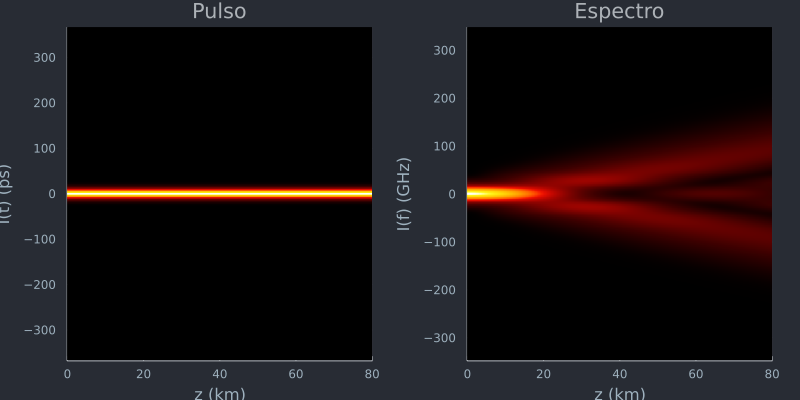

In [16]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2);

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_K9n69i.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_K9n69i.gif")
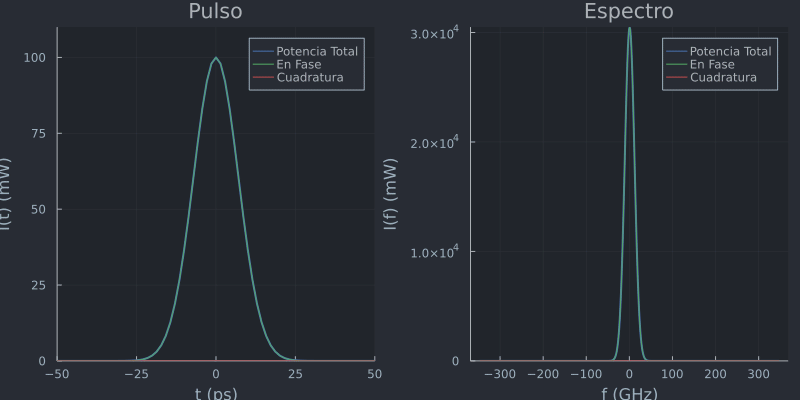

In [17]:
animate_pulse(t, At, f, Af)

Luego con atenuación:

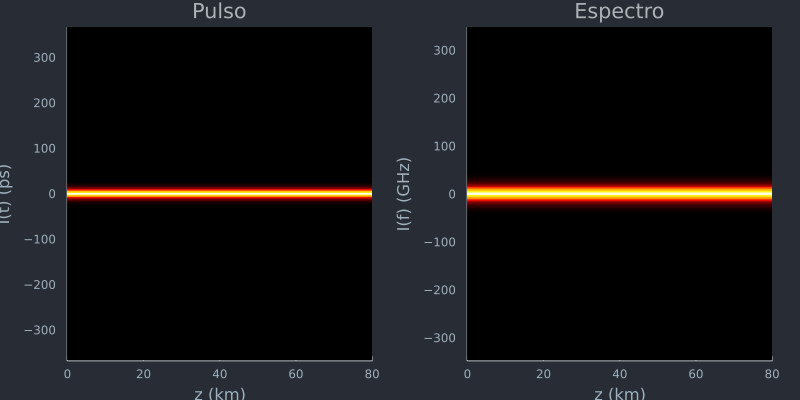

In [18]:
At = A_att.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2);

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_iNUh1r.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_iNUh1r.gif")
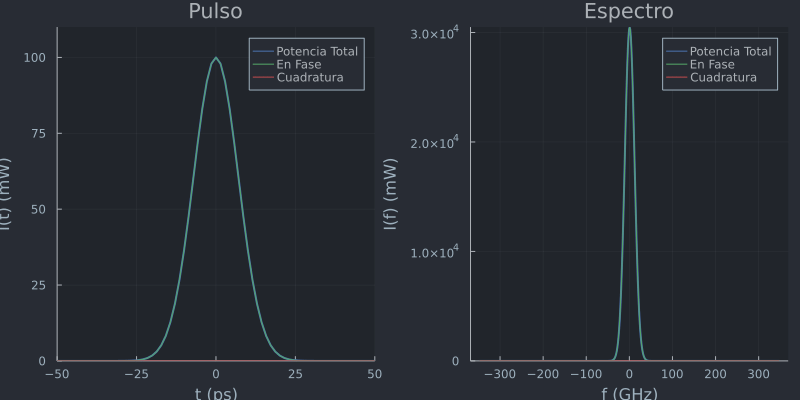

In [19]:
animate_pulse(t, At, f, Af)

Ahora con la fibra TW-RS, primero con un pulso de $10\,\text{mW}$, sin atenuación

In [20]:
fibra = NZ_DSF
P0 = 10u"mW"
At0 = sqrt(P0)*exp.(-t.^2/(2T0^2))

Leff = 1/fibra.α
LNL = 1/(fibra.γ*P0) |> u"km"

println("Longitud característica de atenuación = $Leff\nLongitud característica de no-lineal. = $LNL")

Longitud característica de atenuación = 0.9506047936562816 km
Longitud característica de no-lineal. = 55.55555555555555 km


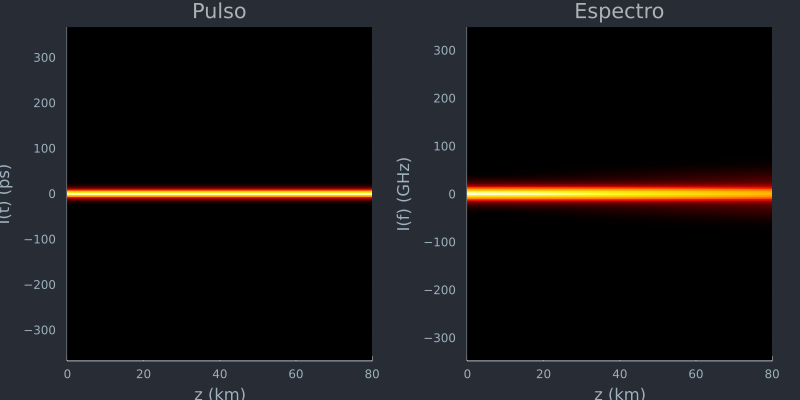

In [21]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2);

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_le8RKw.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_le8RKw.gif")
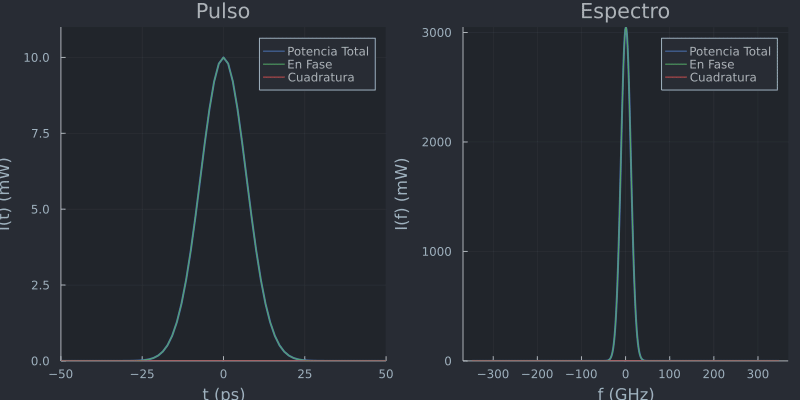

In [22]:
animate_pulse(t, At, f, Af)

Y con atenuación

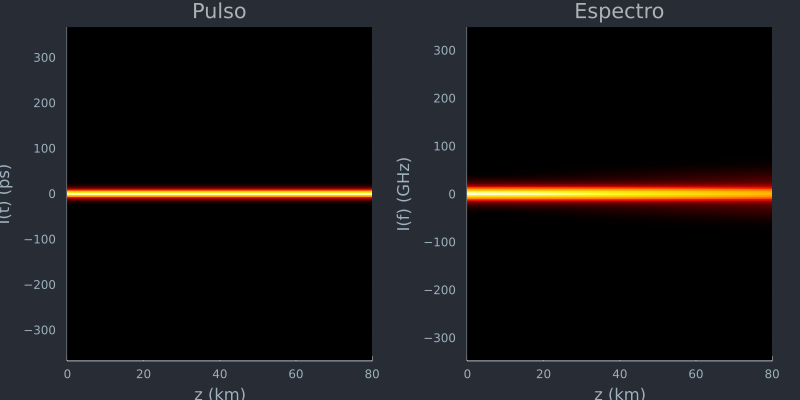

In [23]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2);

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_uUfmrr.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_uUfmrr.gif")
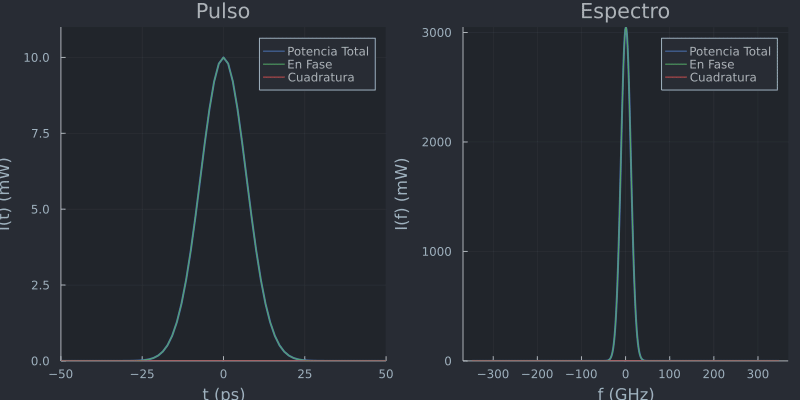

In [24]:
animate_pulse(t, At, f, Af)

Finalmente la fibra TW-RS con un pulso de $100\,\text{mW}$, sin atenuación

In [25]:
fibra = NZ_DSF
P0 = 100u"mW"
At0 = sqrt(P0)*exp.(-t.^2/(2T0^2))

Leff = 1/fibra.α
LNL = 1/(fibra.γ*P0) |> u"km"

println("Longitud característica de atenuación = $Leff\nLongitud característica de no-lineal. = $LNL")

Longitud característica de atenuación = 0.9506047936562816 km
Longitud característica de no-lineal. = 5.555555555555555 km


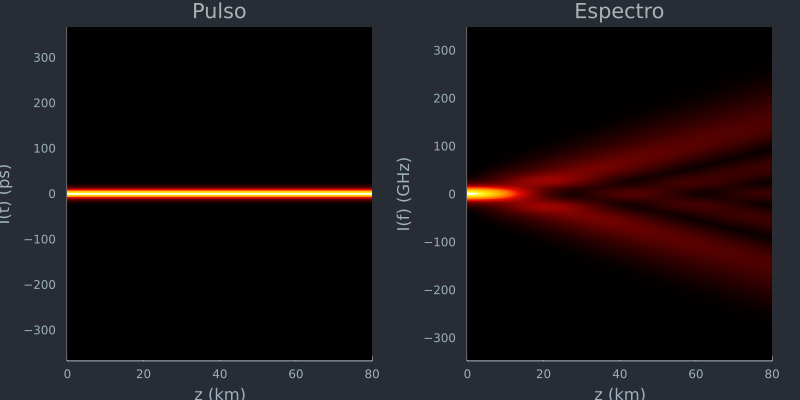

In [26]:
At = A.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2);

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_x9HFkG.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_x9HFkG.gif")
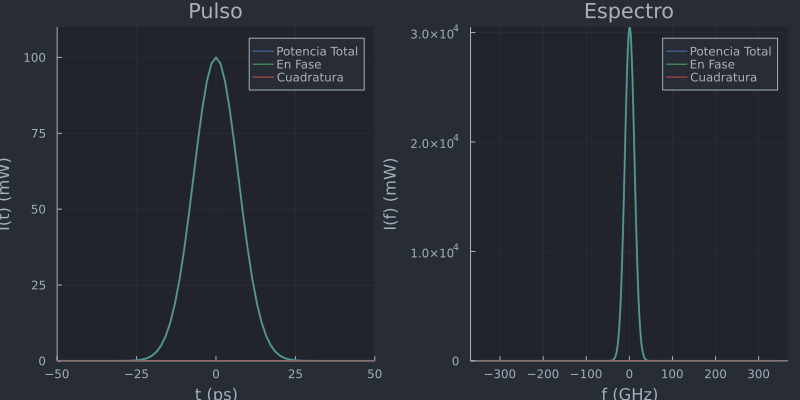

In [27]:
animate_pulse(t, At, f, Af)

Y con atenuación

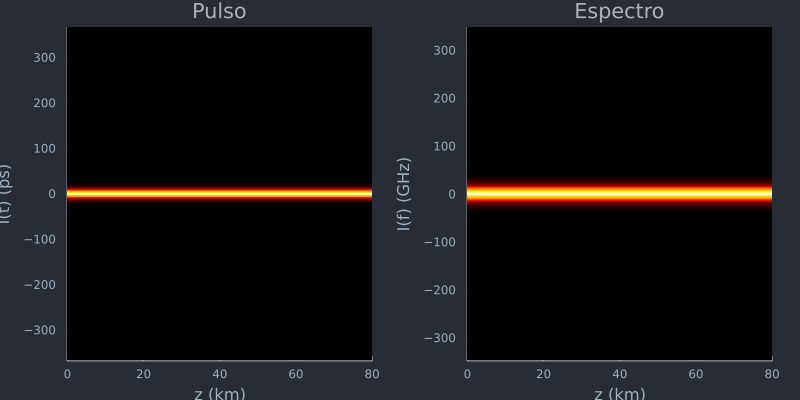

In [28]:
At = A_att.(ij)
Af = ufft(At, 2)
Af = fftshift(Af, 2);

heatmap_pulse(z, t, At, f, Af)

┌ Info: Saved animation to 
│   fn = /tmp/jl_zPidcg.gif
└ @ Plots /home/inox/.julia/packages/Plots/1KWPG/src/animation.jl:114


Plots.AnimatedGif("/tmp/jl_zPidcg.gif")
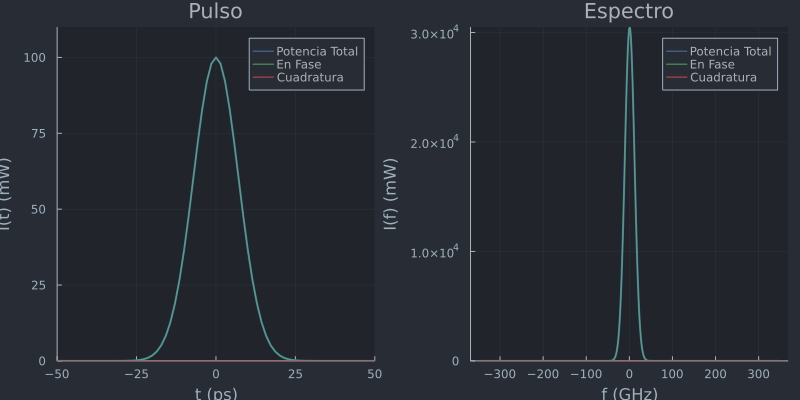

In [29]:
animate_pulse(t, At, f, Af)

En todos los casos se ve que la atenuación efectivamente mata a la SPM muy rápidamente, para estos valores de $\alpha$ y $\gamma$